In [3]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import SelectKBest
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RepeatedKFold, RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.feature_selection import f_regression

import matplotlib.pyplot as plt
import seaborn as sns

In [35]:
df = pd.read_excel("../data/baza danych_CD.xlsx").set_index('No')

X = pd.concat([df.filter(like='before'), df[['Sex, F=1,M=2', 'Age', 'Dis. duration, years', 'Drug, IFX=1,ADA=2']]], axis=1)
X.columns = X.columns.str.split(' before').str[0]
X = X.dropna(thresh=len(X) - 10, axis=1)
# add a couple of random features to the dataset
for i in range(10):
    X[f'_____RANDOM_{i}_____'] = np.random.rand(len(X))

In [17]:
cdai_diff_norm = ((df['CDAI, after'] - df['CDAI before']) / df['CDAI before']).rename('CDAI diff norm')
cdai_diff = (df['CDAI, after'] - df['CDAI before']).rename('CDAI diff')
cdai = df['CDAI, after'].rename('CDAI')
# y = (df['D CDAI'] < -100)*1
# y = df['D CDAI']
# y = df['CRP after, mg/L'] < 5
# y = df['CRP after, mg/L']

# y = y.rename('response')

In [6]:
from utils import test_two_groups

data = pd.concat([X, y], axis=1)

imputer = SimpleImputer(strategy='median')
data = pd.DataFrame(imputer.fit_transform(data), columns=data.columns, index=data.index)

test_two_groups(data, 'response', alpha = 0.05)

Test results for response:
Group counts: 1 | 1
No significant differences found


In [7]:
correlation_matrix = data.corr().abs()
correlation_pairs = correlation_matrix.unstack().sort_values(ascending=False)
correlation_pairs = correlation_pairs[correlation_pairs != 1]  # Exclude self-correlations
correlation_pairs = correlation_pairs.reset_index()
correlation_pairs.columns = ['Feature 1', 'Feature 2', 'Correlation']
correlation_pairs.head(20)

,Feature 1,Feature 2,Correlation
0,Hct,Hb,0.972518
1,Hb,Hct,0.972518
2,AT1R-Ab,ETAR-Ab,0.969420
3,ETAR-Ab,AT1R-Ab,0.969420
4,MCH,MCV,0.965511
5,MCV,MCH,0.965511
6,WBC,PMN,0.960801
7,PMN,WBC,0.960801
8,VEGF-A-Ab,AT1R-Ab,0.940895
9,AT1R-Ab,VEGF-A-Ab,0.940895


In [8]:
correlation_pairs[correlation_pairs['Feature 1'] == 'response'].head(50)

,Feature 1,Feature 2,Correlation
448,response,Leptin,0.292026
608,response,"Sex, F=1,M=2",0.265370
722,response,VEGF-A-Ab,0.247351
775,response,IL-6,0.238093
801,response,Age,0.234154
832,response,CRP,0.229564
862,response,ETAR-Ab,0.225965
871,response,AT1R-Ab,0.225012
971,response,_____RANDOM_4_____,0.211115
988,response,VEGFR1-Ab,0.208063


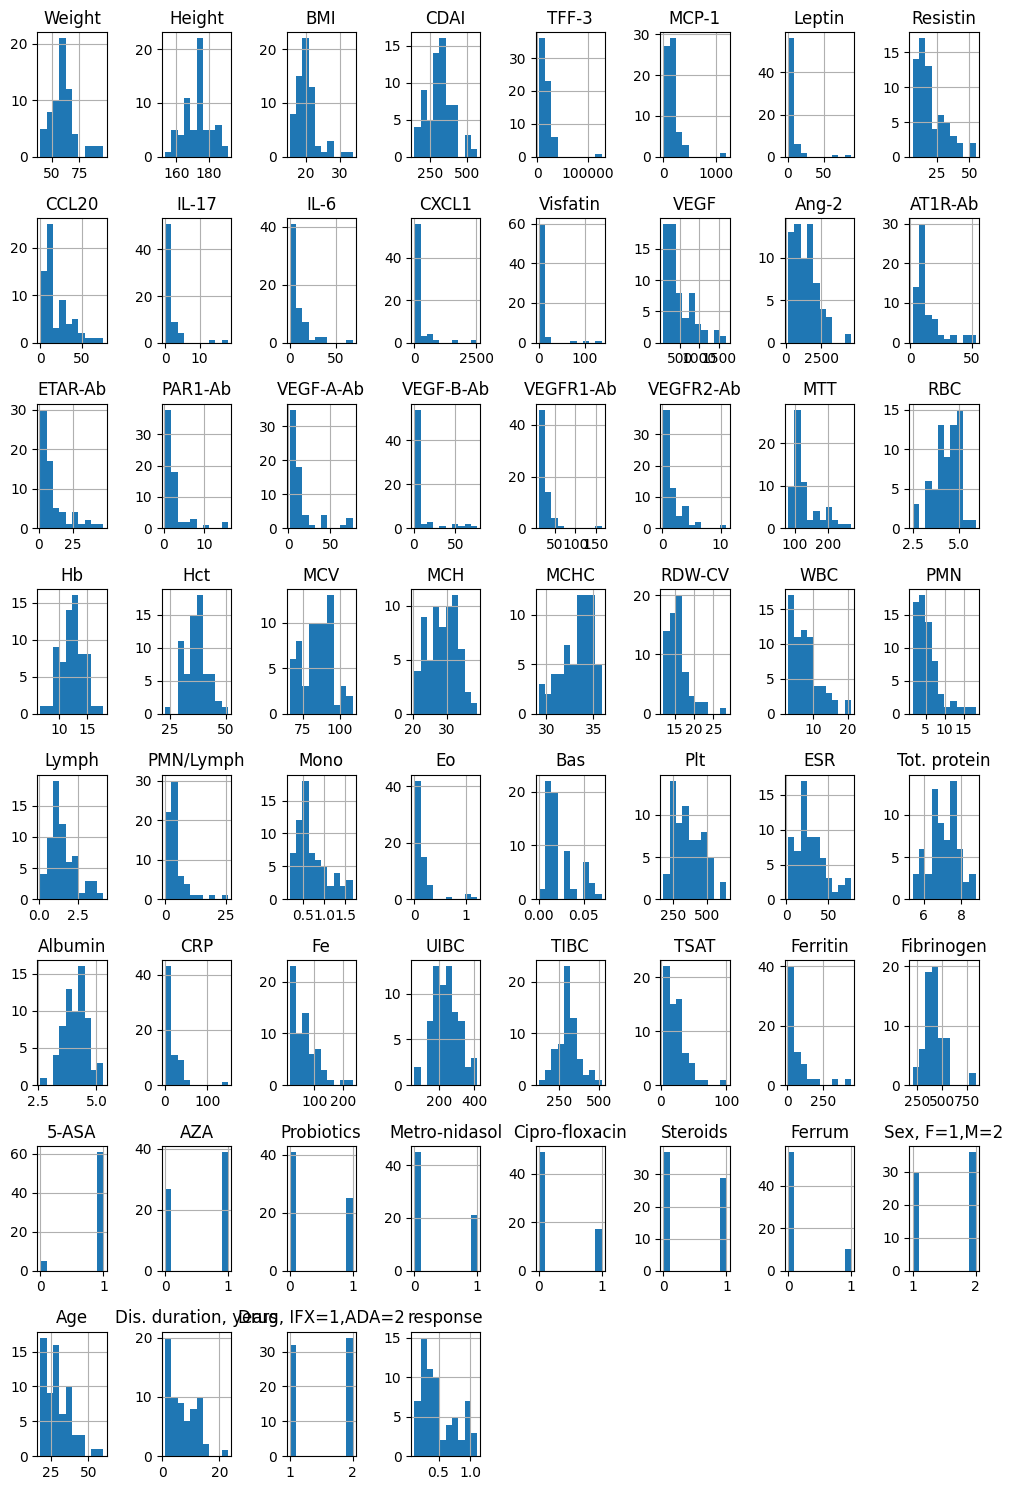

In [36]:
plot_data = data.drop(columns=data.filter(like='RANDOM').columns)
plot_data.hist(figsize=(10, 15))
plt.tight_layout()
plt.show()

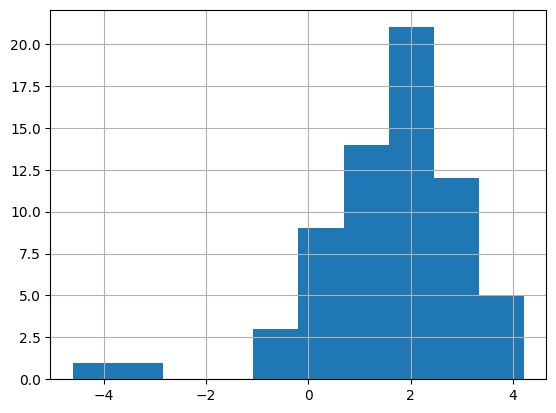

In [40]:
plot_data = np.log(data['IL-6'])
plot_data.hist()
plt.show()

In [47]:
correlation = df['D CDAI'].corr(np.log(data['IL-6']))
print(correlation)

0.10310722990888836


In [29]:
response_definitions = [cdai_diff_norm, cdai_diff, cdai]

pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('model', RandomForestRegressor(n_estimators=1000)),
])

outer_cv = RepeatedKFold(n_splits=5, n_repeats=4, random_state=23)

results = pd.DataFrame()
for response in response_definitions:
    scores = cross_val_score(pipeline, X=X.drop(columns=X.filter(like='RANDOM').columns), y=response, cv=outer_cv, scoring='neg_mean_absolute_error')
    results[response.name] = scores

    # add results for a model only on random features
    scores = cross_val_score(pipeline, X=X.filter(like='RANDOM'), y=response, cv=outer_cv, scoring='neg_mean_absolute_error')
    results[f'RANDOM {response.name}'] = scores

results = results.abs()

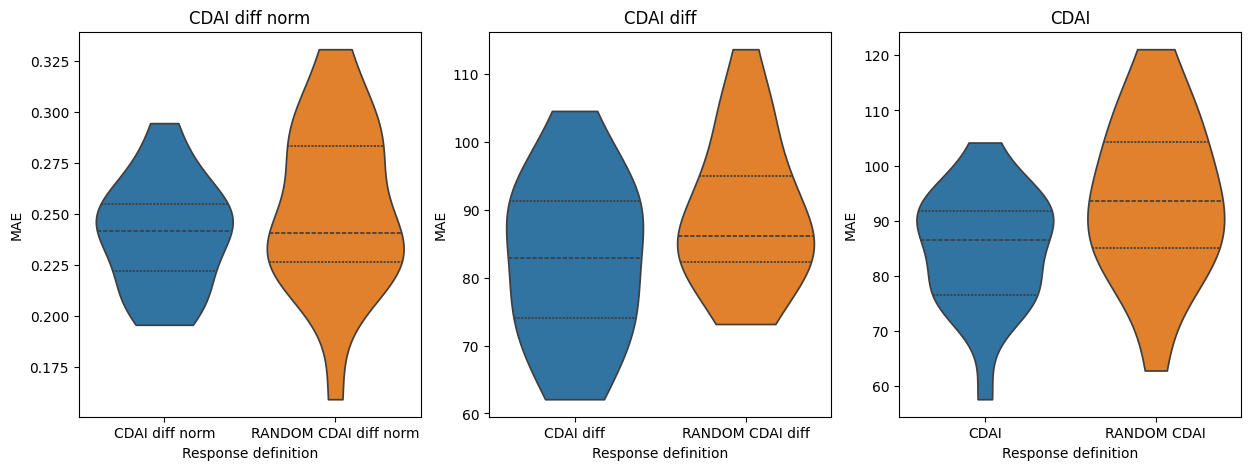

In [30]:
# plot the results again, but this time each violinplot on a separate axis
fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
for i, response in enumerate(response_definitions):
    sns.violinplot(data=results[[response.name, f'RANDOM {response.name}']], ax=ax[i], cut=0, inner='quartile')
    ax[i].set_title(response.name)
    ax[i].set_ylabel('MAE')
    ax[i].set_xlabel('Response definition')

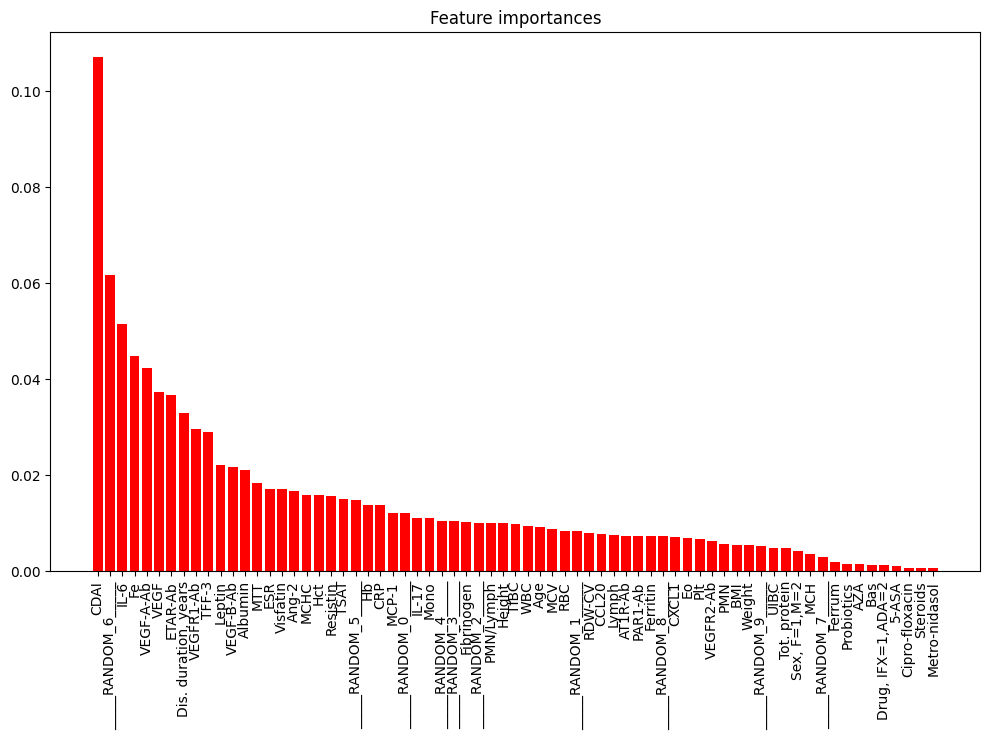

In [36]:
import matplotlib.pyplot as plt

pipeline.fit(X, cdai)

importances = pipeline[-1].feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 7))
plt.title("Feature importances")
plt.bar(X.columns[indices], importances[indices], color="r", align="center")
plt.xticks(rotation=90)
plt.show()

In [ ]:
# potencjalnie obieujące cechy
# albumina, CRP, IL-6, BMI, SES-CD, hsTNF, hemoglobina, płytki krwi, RDW, MCV lub MCHC


In [59]:
selected_features = ['Albumin', 'CRP', 'IL-6', 'BMI', 'Hb', 'Plt', 'MCV', 'MCHC', 'RDW-CV']

results = pd.DataFrame()
for response in response_definitions:
    scores = cross_val_score(pipeline, X=X[selected_features], y=response, cv=outer_cv, scoring='neg_mean_absolute_error')
    results[response.name] = scores

    scores = cross_val_score(pipeline, X=X.filter(like='RANDOM'), y=response, cv=outer_cv, scoring='neg_mean_absolute_error')
    results[f'RANDOM {response.name}'] = scores

results = results.abs()

ValueError: 
All the 20 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/bio/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/bio/lib/python3.11/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/bio/lib/python3.11/site-packages/sklearn/pipeline.py", line 423, in fit
    Xt = self._fit(X, y, **fit_params_steps)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/bio/lib/python3.11/site-packages/sklearn/pipeline.py", line 377, in _fit
    X, fitted_transformer = fit_transform_one_cached(
                            ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/bio/lib/python3.11/site-packages/joblib/memory.py", line 353, in __call__
    return self.func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/bio/lib/python3.11/site-packages/sklearn/pipeline.py", line 957, in _fit_transform_one
    res = transformer.fit_transform(X, y, **fit_params)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/bio/lib/python3.11/site-packages/sklearn/utils/_set_output.py", line 157, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/bio/lib/python3.11/site-packages/sklearn/base.py", line 919, in fit_transform
    return self.fit(X, y, **fit_params).transform(X)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/bio/lib/python3.11/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/bio/lib/python3.11/site-packages/sklearn/impute/_base.py", line 369, in fit
    X = self._validate_input(X, in_fit=True)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/bio/lib/python3.11/site-packages/sklearn/impute/_base.py", line 332, in _validate_input
    raise ve
  File "/opt/anaconda3/envs/bio/lib/python3.11/site-packages/sklearn/impute/_base.py", line 315, in _validate_input
    X = self._validate_data(
        ^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/bio/lib/python3.11/site-packages/sklearn/base.py", line 605, in _validate_data
    out = check_array(X, input_name="X", **check_params)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/bio/lib/python3.11/site-packages/sklearn/utils/validation.py", line 795, in check_array
    dtype_orig = np.result_type(*dtypes_orig)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: at least one array or dtype is required


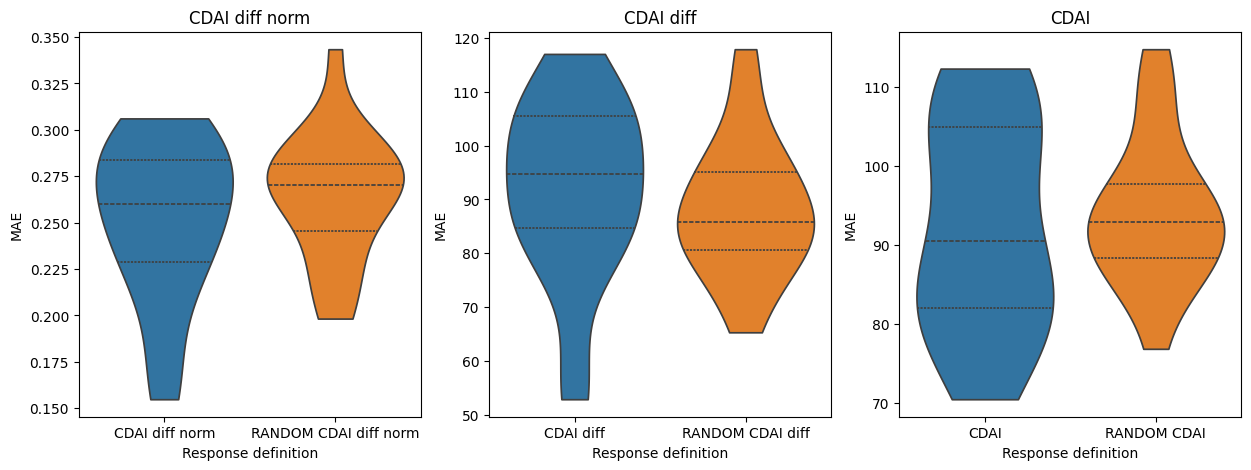

In [ ]:
# plot the results again, but this time each violinplot on a separate axis
fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
for i, response in enumerate(response_definitions):
    sns.violinplot(data=results[[response.name, f'RANDOM {response.name}']], ax=ax[i], cut=0, inner='quartile')
    ax[i].set_title(response.name)
    ax[i].set_ylabel('MAE')
    ax[i].set_xlabel('Response definition')

In [44]:
df = pd.read_excel("../data/baza danych_CD.xlsx").set_index('No')

X = pd.concat([df.filter(like='before'), df[['Sex, F=1,M=2', 'Age', 'Dis. duration, years', 'Drug, IFX=1,ADA=2']]], axis=1)
X.columns = X.columns.str.split(' before').str[0]

In [60]:
pd.concat([X['hsTNF'], cdai], axis=1).dropna().corr()

,hsTNF,CDAI
hsTNF,1.000000,0.333331
CDAI,0.333331,1.000000


In [65]:
cor = pd.concat([X.drop('CDAI', axis=1), cdai], axis=1).dropna().corr()

In [67]:
cor['CDAI'].sort_values(ascending=False).abs().head(20)

CDAI              1.000000
IL-6              0.762272
Ferrum            0.731634
Ferritin          0.695717
CRP               0.581131
MTT               0.579145
ESR               0.574997
IL-17             0.489581
MCHC              0.447898
SES-CD            0.428632
Mono              0.390769
hsTNF             0.361491
Fibrinogen        0.318287
CCL20             0.285235
Resistin          0.254222
5-ASA             0.247663
RBC               0.240790
Age               0.232657
Cipro-floxacin    0.225693
Height            0.225258
Name: CDAI, dtype: float64

Ścieżki 
- dokończyć dane CD
- SMPT - pon, wt, czw
- kontynuacja zbierania RNASeq